## Organ differences by Milo - myeloid

In [264]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [265]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
import scvelo as scv

In [266]:
import milopy.core as milo
import milopy.plot as milopl

In [3]:
## import project utils
cwd = '../utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

In [4]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/organ_milo_analysis_MYELOID/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir

In [5]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython


In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [8]:
import milopy

def annotate_nhoods(adata, anno_col):
    anno_dummies = pd.get_dummies(adata.obs[anno_col])
    anno_count = adata.obsm["nhoods"].T.dot(scipy.sparse.csr_matrix(anno_dummies.values))
    anno_frac = np.array(anno_count/anno_count.sum(1))

    anno_frac = pd.DataFrame(anno_frac, 
                             columns=anno_dummies.columns,
                             index=adata.uns["nhood_adata"].obs_names
                            )
    adata.uns["nhood_adata"].obsm["frac_annotation"] = anno_frac.values
    adata.uns["nhood_adata"].uns["annotation_labels"] = anno_frac.columns
    adata.uns["nhood_adata"].obs["nhood_annotation"] = anno_frac.idxmax(1)
    adata.uns["nhood_adata"].obs["nhood_annotation_frac"] = anno_frac.max(1)

## Load milo neighbourhoods
Computed in `src/7_differential_abundance`

In [9]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="MYELOID_V2"

In [10]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_outs/{s}/'.format(s=split)
adata = sc.read_h5ad(outdir + "adata4milo.{s}.h5ad".format(s=split))

In [11]:
nhood_adata = sc.read_h5ad(outdir + "milo_nhood_adata.{s}.h5ad".format(s=split))

adata.uns["nhood_adata"] = nhood_adata.copy()

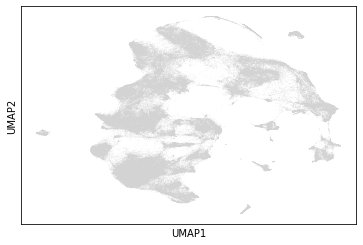

In [13]:
sc.pl.umap(adata)

### Make neighbourhoods
Larger neighbourhoods than for analysis in time (more samples per condition)

In [14]:
## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 100, key_added="scvi")

## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="scvi", prop=0.05)

## Count cells in neighbourhoods
milo.count_nhoods(adata, sample_col="Sample.lanes")

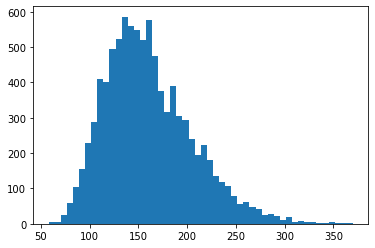

In [15]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=50);

### Test for enrichment of an organ

In [15]:
# def _milo_test_organ_abundance(adata, org, design = '~ method + correction_factor + test_organ'):
#     adata.obs['test_organ'] = adata.obs.organ==org
#     adata.obs['test_organ'] = adata.obs['test_organ'].astype("str").astype("category")
#     milopy.utils.add_covariate_to_nhoods_var(adata, ['test_organ'])
#     milo.DA_nhoods(adata, design=design)

# milopy.utils.add_covariate_to_nhoods_var(adata, ['method', 'Sort_id', 'donor'])
# all_organs = adata.obs.organ.unique().tolist()
# design = '~ method + correction_factor + test_organ'

# ## Calculate logFC and SpatialFDR within each organ
# milo_res_dict = {}
# for org in all_organs:
#     print(org)
#     _milo_test_organ_abundance(adata, org, design)
#     milo_res_dict[org] = adata.uns["nhood_adata"].obs.copy()

SK
SP
YS
LI
TH
GU
BM
KI


In [113]:
import milopy.core as milo
import milopy.plot as milopl

In [ ]:
adata.obs['organ'] = adata.obs['organ'].astype("category")
milopy.utils.add_covariate_to_nhoods_var(adata, ['method', 'Sort_id', 'donor', 'organ'])
adata.uns['nhood_adata'].var['organ'] = adata.uns['nhood_adata'].var['organ'].astype('category')
all_organs = adata.obs.organ.unique().tolist()
design = '~ method + correction_factor + organ'

## Calculate logFC and SpatialFDR within each organ
milo_res_dict = {}
for org in all_organs:
    print(org)
    if org == adata.uns['nhood_adata'].var.organ.cat.categories[0]:
        nhood_adata = adata.uns['nhood_adata'].copy()
        new_cats = nhood_adata.var.organ.cat.categories[1:].tolist()
        new_cats.append(org)
        nhood_adata.var.organ.cat.reorder_categories(new_cats, inplace=True)
        adata.obs.organ.cat.reorder_categories(new_cats, inplace=True)
        adata.uns['nhood_adata'] = nhood_adata.copy()
#     _milo_test_organ_abundance(adata, org, design)
    milo.DA_nhoods(adata, design=design, model_contrasts='organ{o}'.format(o=org))
    milo_res_dict[org] = adata.uns["nhood_adata"].obs.copy()

In [157]:
## Collapse results
logFC_df_ls = [v["logFC"] for k,v in milo_res_dict.items()]
for k,v in milo_res_dict.items():
    milo_res_dict[k]["logFC_" + k] = milo_res_dict[k]["logFC"].copy()
    milo_res_dict[k]["SpatialFDR_" + k] = milo_res_dict[k]["SpatialFDR"].copy()

org_fc = pd.concat([v[["logFC_" + k]] for k,v in milo_res_dict.items()], 1)
org_fdr = pd.concat([v[["SpatialFDR_" + k]] for k,v in milo_res_dict.items()], 1)

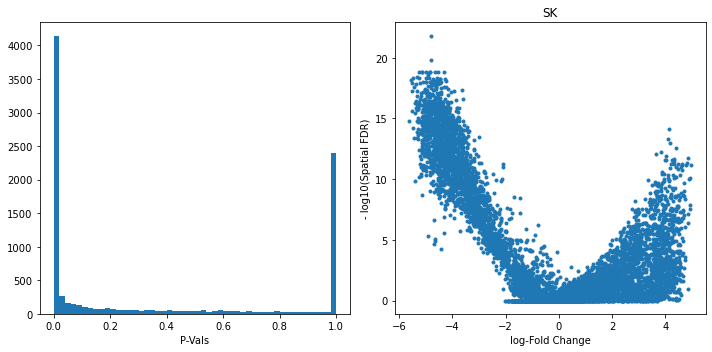

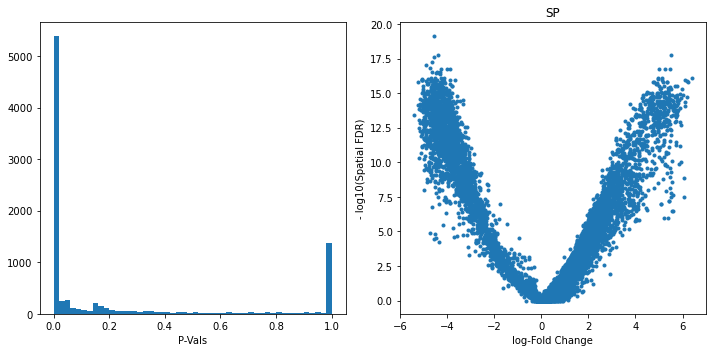

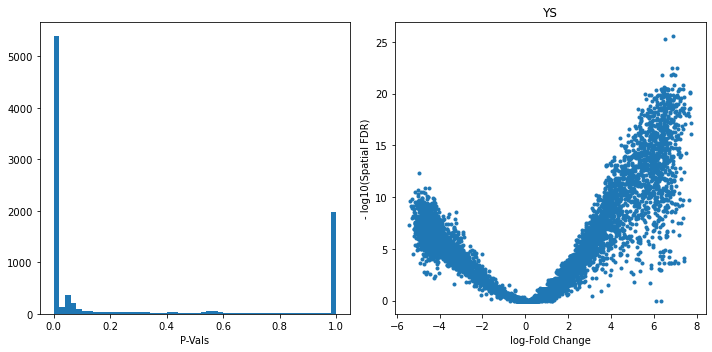

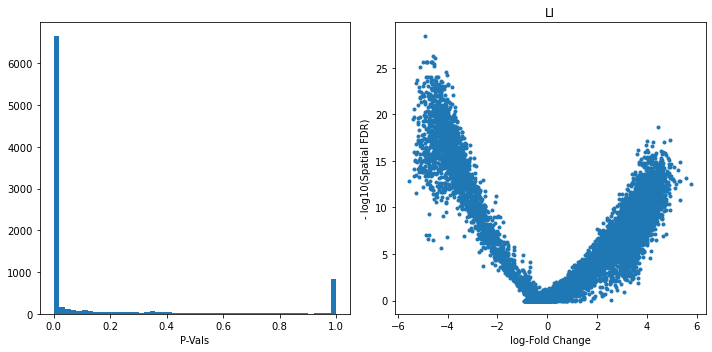

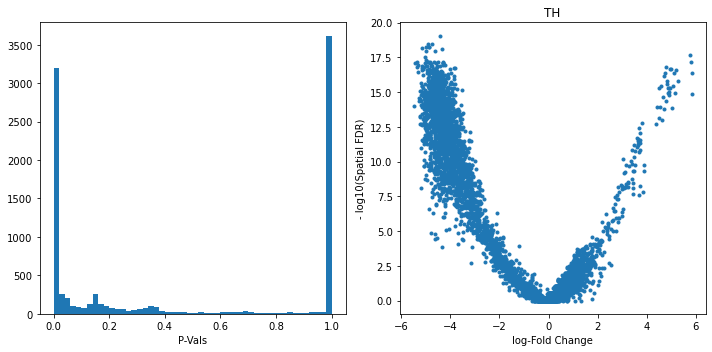

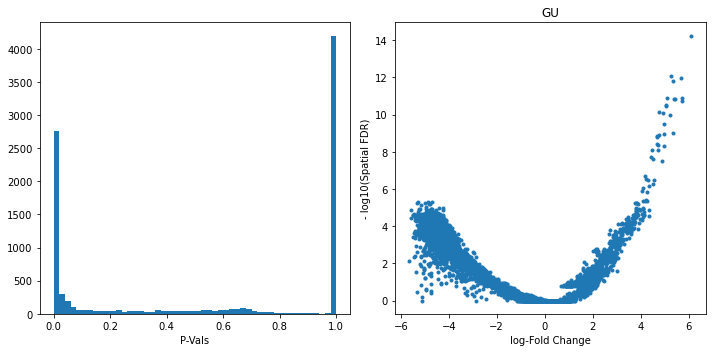

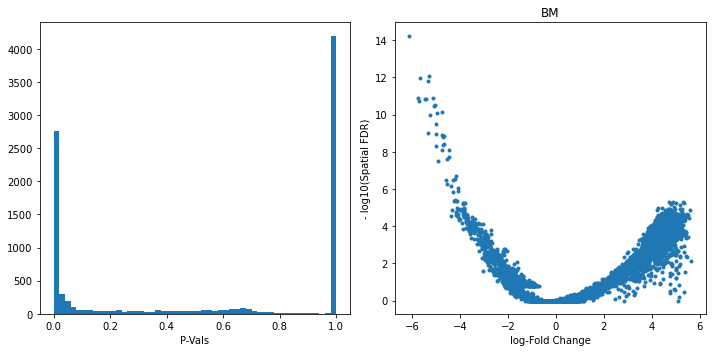

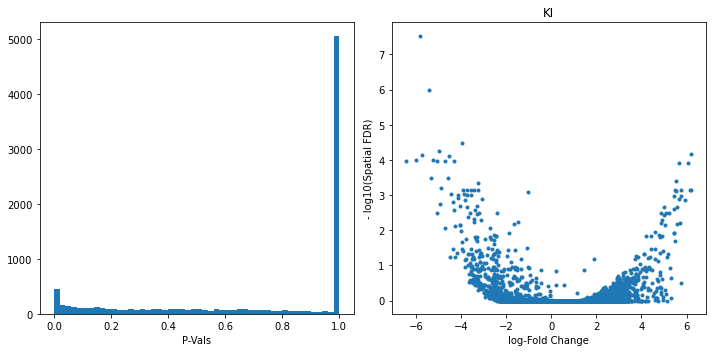

In [158]:
old_figsize = plt.rcParams["figure.figsize"]
for org, milo_res in milo_res_dict.items():
    plt.rcParams["figure.figsize"] = [10,5]
    plt.subplot(1,2,1)
    plt.hist(milo_res.PValue, bins=50);
    plt.xlabel("P-Vals");
    plt.subplot(1,2,2)
    plt.plot(milo_res.logFC, -np.log10(milo_res.SpatialFDR), '.');
    plt.xlabel("log-Fold Change");
    plt.ylabel("- log10(Spatial FDR)");
    plt.title(org);
    plt.tight_layout();
    plt.show()

plt.rcParams["figure.figsize"] = old_figsize

### Plot graph embeddings

In [159]:
milopy.utils.build_nhood_graph(adata)

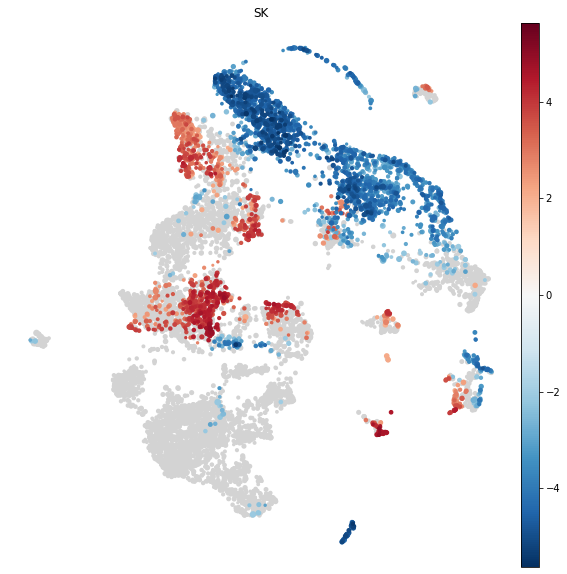

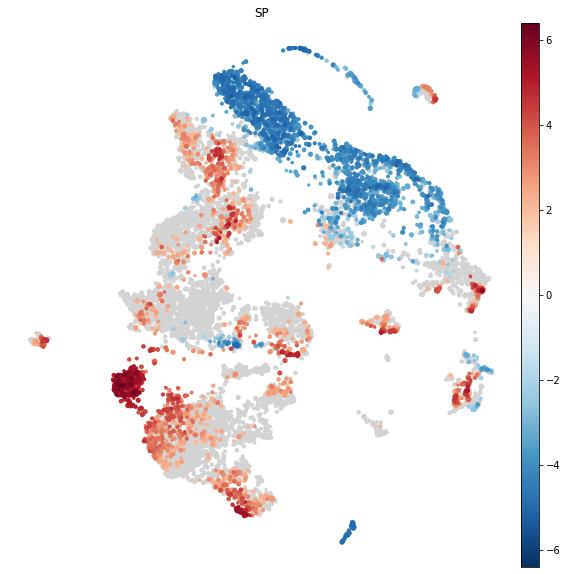

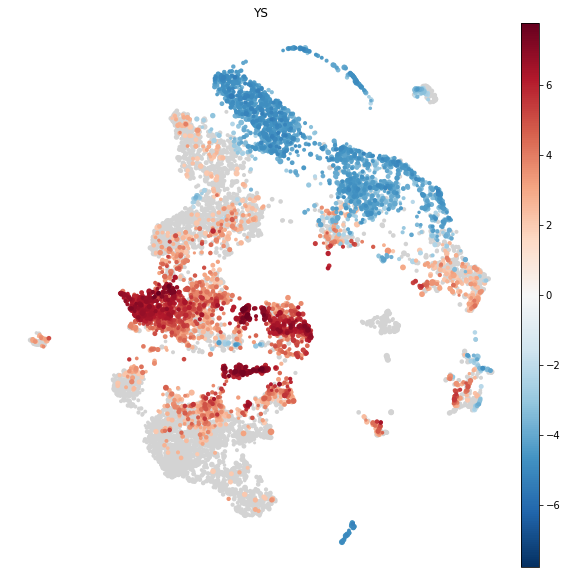

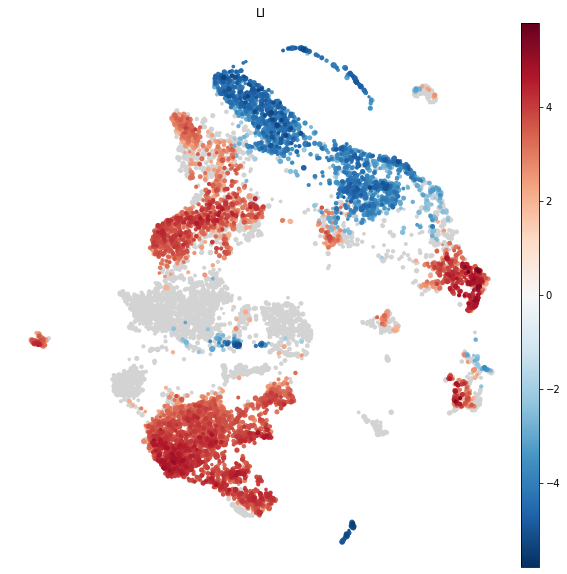

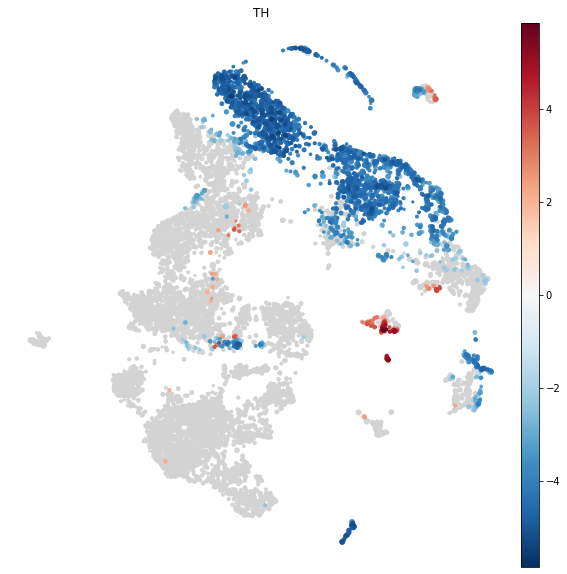

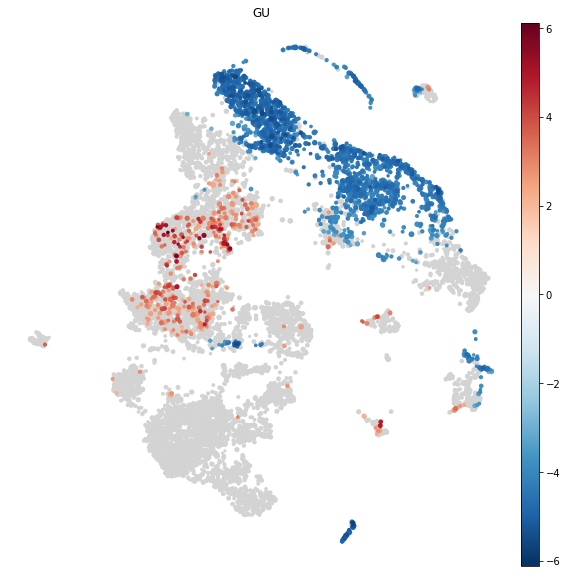

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


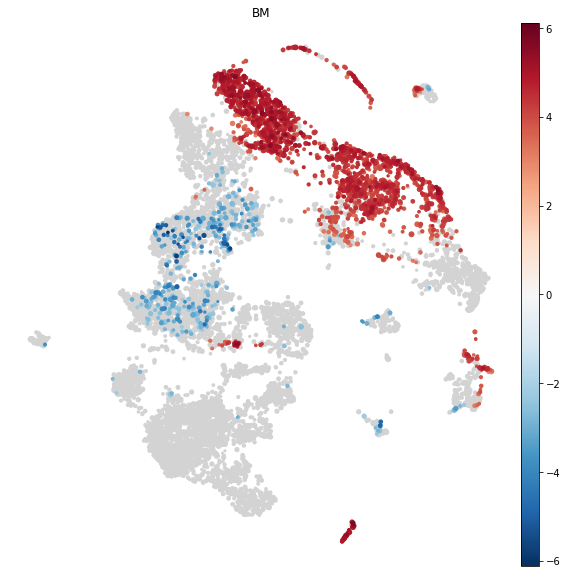

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


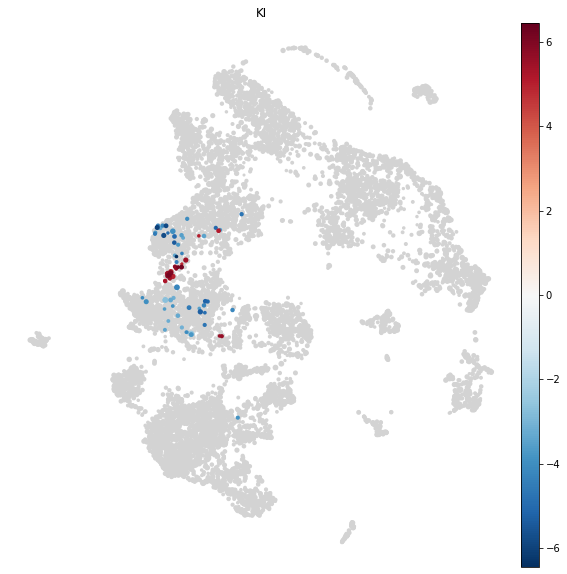

In [186]:
plt.rcParams["figure.figsize"] = [10,10]
milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    milopl.plot_nhood_graph(adata, alpha=0.01, 
                            min_logFC= 2, min_size=0.5, title=org)

In [254]:
alpha = 0.01
min_logFC = 2
min_size=0.5
plot_edges = False
title='ciao'

def plot_nhood_graph_enrichment(nhood_adata, alpha = 0.01,
    min_logFC = 2,
    min_size=0.5,
    plot_edges = False,
    title='ciao',**kwargs):
#     nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = nhood_adata.obs["logFC"]
    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan
    nhood_adata.obs["abs_logFC"] = abs(nhood_adata.obs["logFC"])
    nhood_adata.obs.loc[nhood_adata.obs["abs_logFC"] < min_logFC, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] < 0, "graph_color"] = np.nan

    ## Plotting order - extreme logFC on top
    nhood_adata.obs.loc[nhood_adata.obs["graph_color"].isna(), "abs_logFC"] = np.nan
    ordered = nhood_adata.obs.sort_values('abs_logFC', na_position='first').index
    nhood_adata = nhood_adata[ordered]

#     vmax = np.max([nhood_adata.obs["graph_color"].max(), abs(nhood_adata.obs["graph_color"].min())])
    vmin = 0

    sc.pl.embedding(nhood_adata, "X_milo_graph", 
                    color="graph_color", cmap="Reds",
                    size=nhood_adata.obs["Nhood_size"]*min_size, 
                    edges=plot_edges, neighbors_key="nhood",
                    # edge_width = 
                    sort_order=False,
                    frameon=False,
#                     vmax=vmax, 
                    vmin=vmin,
                    title=title,
                    **kwargs
                   )

In [260]:
plt.rcParams["figure.figsize"] = [7,7]
sns.set_context("talk")
sc.pl.embedding(nhood_adata, "X_milo_graph", 
                color="nhood_annotation",
                size=nhood_adata.obs["Nhood_size"]*min_size, 
                edges=plot_edges, neighbors_key="nhood",
                # edge_width = 
                sort_order=False,
                frameon=False,
#                     vmax=vmax, 
                vmin=vmin,
                title='',
                legend_loc="on data",
                save='nhood_graph_mono_anno.pdf'
               )


# milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
    nhood_adata = adata.uns["nhood_adata"][adata.uns["nhood_adata"].obs['nhood_annotation'].isin(anno_group_myeloid['Mono'])].copy()
    plot_nhood_graph_enrichment(nhood_adata, alpha=0.01, min_logFC= 2, min_size=0.5, title=org, 
                                save='nhood_graph_mono_{o}.pdf'.format(o=org))

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


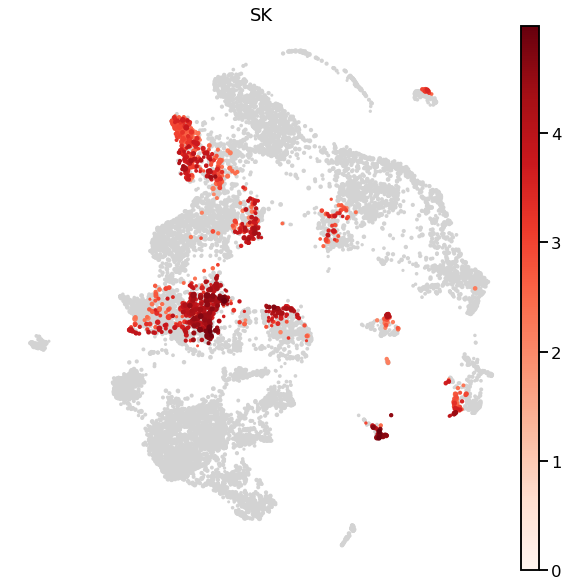

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


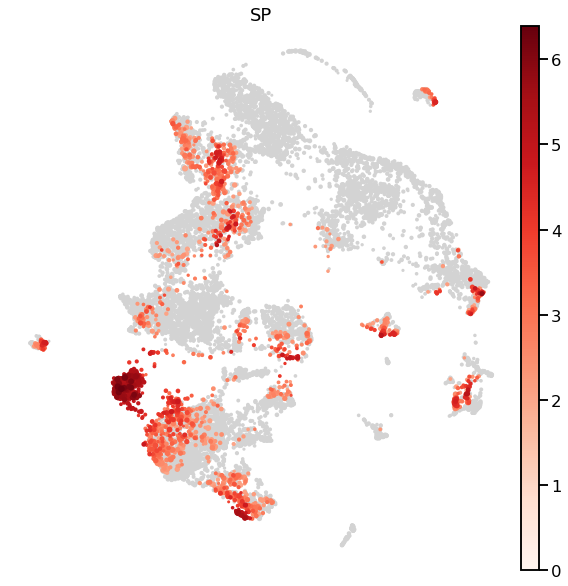

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


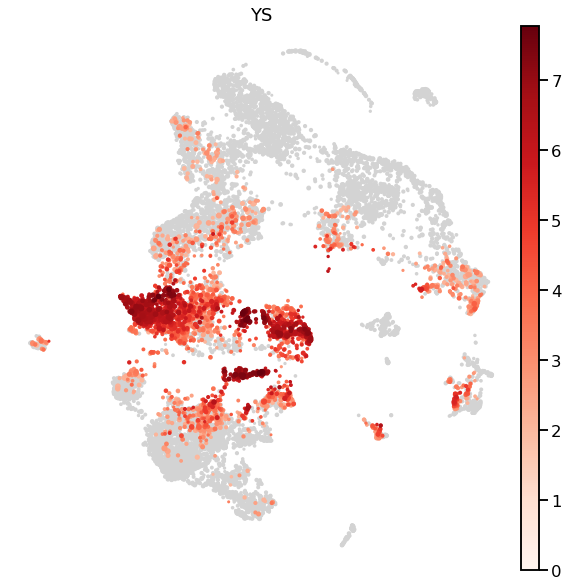

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


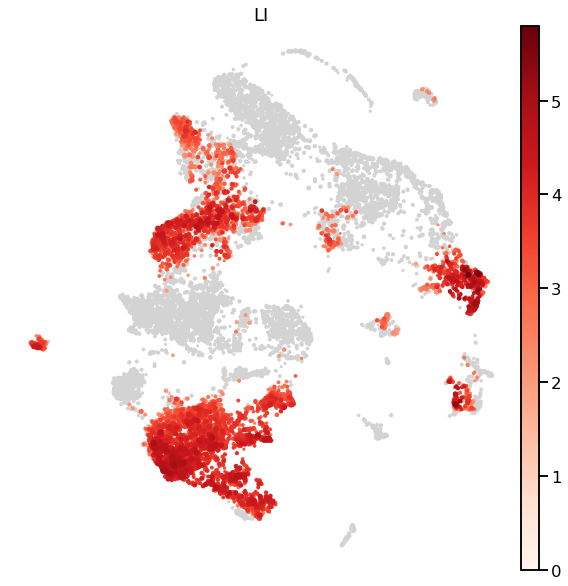

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


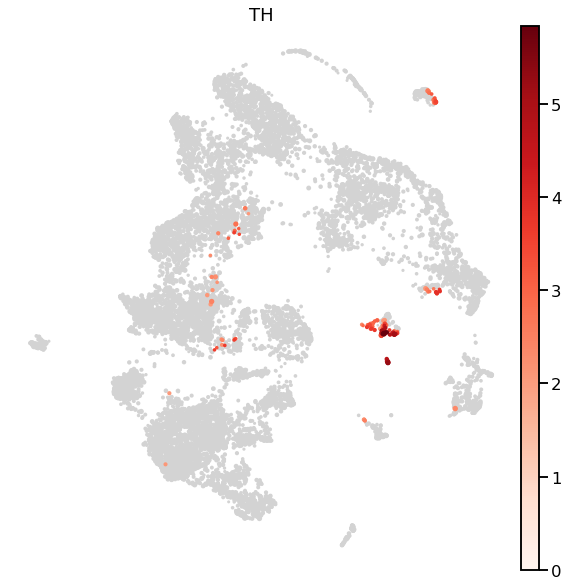

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


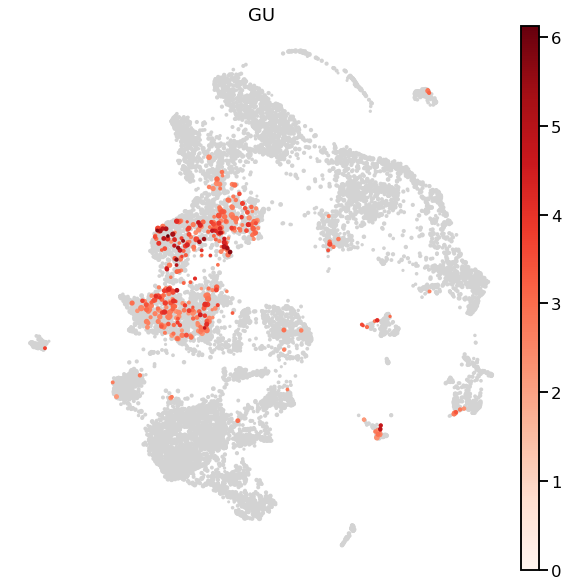

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


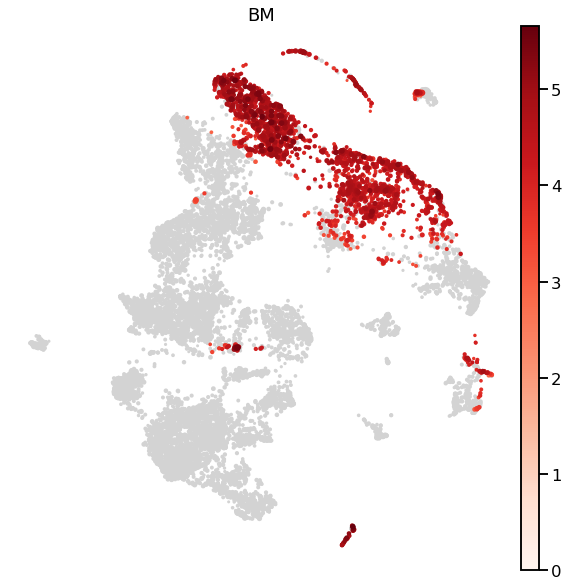

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


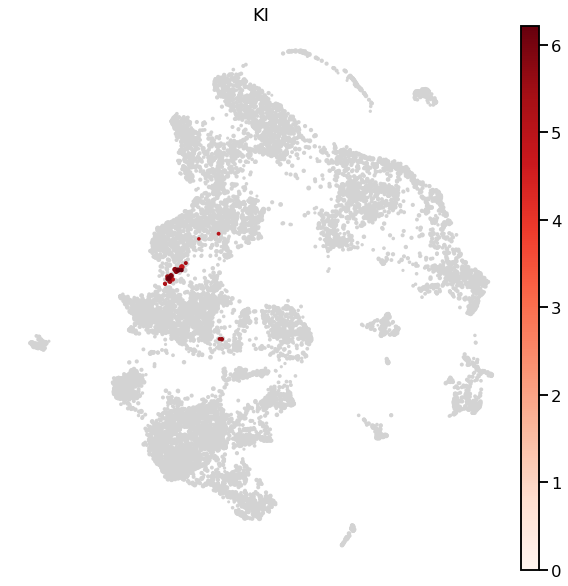

In [263]:
plt.rcParams["figure.figsize"] = [10,10]
sns.set_context("talk")

# milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
    nhood_adata = adata.uns["nhood_adata"].copy()
    plot_nhood_graph_enrichment(nhood_adata, alpha=0.01, min_logFC= 2, min_size=0.5, title=org, 
                                save='nhood_graph_{o}.pdf'.format(o=org))

### Monocyte figure

In [260]:
plt.rcParams["figure.figsize"] = [7,7]
sns.set_context("talk")
sc.pl.embedding(nhood_adata, "X_milo_graph", 
                color="nhood_annotation",
                size=nhood_adata.obs["Nhood_size"]*min_size, 
                edges=plot_edges, neighbors_key="nhood",
                # edge_width = 
                sort_order=False,
                frameon=False,
#                     vmax=vmax, 
                vmin=vmin,
                title='',
                legend_loc="on data",
                save='nhood_graph_mono_anno.pdf'
               )


# milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
    nhood_adata = adata.uns["nhood_adata"][adata.uns["nhood_adata"].obs['nhood_annotation'].isin(anno_group_myeloid['Mono'])].copy()
    plot_nhood_graph_enrichment(nhood_adata, alpha=0.01, min_logFC= 2, min_size=0.5, title=org, 
                                save='nhood_graph_mono_{o}.pdf'.format(o=org))

### Visualize with beeswarm plot

In [161]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
    

In [162]:
org_fc_filtered = org_fc.copy()
org_fc_filtered.values[org_fdr.values > 0.1] = 0

In [163]:
## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

In [164]:
anno_group_myeloid = {
    "MACs":[x for x in org_fc_filtered.nhood_anno.unique() if "ACROPHAGE" in x],
    'DCs':[x for x in org_fc_filtered.nhood_anno.unique() if "DC" in x],
    "Mono":[x for x in org_fc_filtered.nhood_anno.unique() if "MONO" in x],
    "Progenitors":anno_groups_dict["PROGENITORS"]
    }

anno_group_myeloid['other'] = [x for x in org_fc_filtered.nhood_anno.unique() if x not in sum(anno_group_myeloid.values(),[])]
anno_group_myeloid_rev = {x:g for g,a in anno_group_myeloid.items() for x in a}

In [165]:
org_fc_filtered['anno_group'] = [anno_group_myeloid_rev[x] for x in org_fc_filtered['nhood_anno']]

In [166]:
%%R -i org_fc_filtered -i org_fdr -h 1000 -w 800

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 
    
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ## Fix some names
    mutate(nhood_anno=ifelse(str_detect(nhood_anno, "NK$"), "NK", nhood_anno)) %>%
    ## Reorder by fold-change 
    group_by(organ, nhood_anno, Nhood) %>%
    mutate(mean_logFC = mean(logFC)) %>%
    ungroup() %>%
    group_by(organ, nhood_anno) %>%
    arrange(- mean_logFC) %>%
    ungroup()  %>%
    mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
    group_by(nhood_anno) %>%
    filter(length(unique(Nhood)) > 20) %>%
    ungroup()

head(plot_df)

Joining, by = c("Nhood", "organ")
  Nhood     nhood_anno anno_group organ    logFC   SpatialFDR mean_logFC
1    77 MACROPHAGE_III       MACs    YS 7.762319 7.867324e-17   7.762319
2  3460   MACROPHAGE_I       MACs    YS 7.729238 7.656428e-18   7.729238
3  2870   MACROPHAGE_I       MACs    YS 7.704757 9.467564e-21   7.704757
4  3435   MACROPHAGE_I       MACs    YS 7.698141 6.335116e-21   7.698141
5  2838   MACROPHAGE_I       MACs    YS 7.685297 2.691975e-19   7.685297
6    45 MACROPHAGE_III       MACs    YS 7.654682 1.771584e-10   7.654682


In [167]:
%%R -w 1200 -h 600 -i figdir -o pl_df
library(ggbeeswarm)
organ_colors_df <- read.csv("~/Pan_fetal_immune/metadata/organ_colors.csv")
organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)

anno_group_order <- c('Progenitors', 'DCs', 'Mono','MACs',  'low_confidence', 'other')

pl_df <- plot_df %>%
    mutate(logFC=ifelse(logFC > 0, logFC, 0)) %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=unique(nhood_anno))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% anno_group_order)

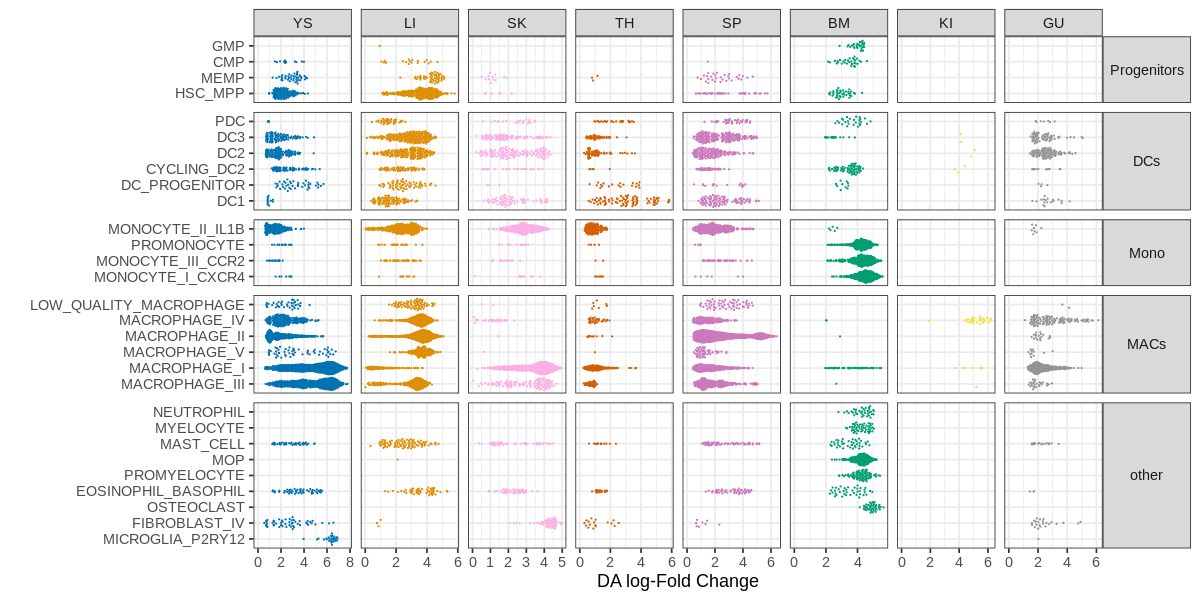

In [168]:
%%R -w 1200 -h 600
alpha=0.1
set.seed(12345)
pl1 <- 
    pl_df %>%
    mutate(organ_color=ifelse((SpatialFDR < alpha) & (logFC > 0), as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
#     geom_quasirandom(size=0.2, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.4, aes(color=organ_color)) +
#     geom_violin(data=. %>% filter(SpatialFDR < alpha), aes(color=organ_color)) +
#     geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=organ_palette) +
    scale_fill_manual(values=organ_palette) +
    guides(color="none", fill="none") +
    theme_bw(base_size=18) +
    xlab("") + ylab("DA log-Fold Change") +
    theme(strip.text.y=element_text(angle=0))
    
pl1
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

### Visualize with heatmaps

In [169]:
min_lfc = 2
org_fc_filtered = org_fc.copy()
org_fc_filtered.values[org_fdr.values > 0.1] = 0
org_fc_filtered.values[org_fc_filtered.values < min_lfc] = 0

## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

## Add annotation grouping
anno_group_myeloid = {
    "MACs":[x for x in org_fc_filtered.nhood_anno.unique() if "ACROPHAGE" in x],
    'DCs':[x for x in org_fc_filtered.nhood_anno.unique() if "DC" in x],
    "Mono":[x for x in org_fc_filtered.nhood_anno.unique() if "MONO" in x],
    "Progenitors":anno_groups_dict["PROGENITORS"]
    }

anno_group_myeloid['other'] = [x for x in org_fc_filtered.nhood_anno.unique() if x not in sum(anno_group_myeloid.values(),[])]
anno_group_myeloid_rev = {x:g for g,a in anno_group_myeloid.items() for x in a}

org_fc_filtered['anno_group'] = [anno_group_myeloid_rev[x] for x in org_fc_filtered['nhood_anno']]

In [170]:
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

org_fc_filtered["hclust_order"] = np.nan
for a in org_fc_filtered.nhood_anno.unique():
    ## Keep high FCs
    
    df = org_fc_filtered[org_fc_filtered.nhood_anno==a].drop(['nhood_anno', 'anno_group', 'hclust_order'], 1)
    clustering = ward(df.values)
    ordered_ixs = org_fc_filtered.index[org_fc_filtered.nhood_anno==a][leaves_list(clustering)]
    org_fc_filtered.loc[ordered_ixs, 'hclust_order'] = np.arange(sum(org_fc_filtered.nhood_anno==a))

In [171]:
anno_order = [
    ## Monocytes
    'PROMONOCYTE', 
    'MONOCYTE_I_CXCR4',
    'MONOCYTE_II_IL1B', 
    'MONOCYTE_III_CCR2',
    ## MA
]

In [172]:
%%R -i org_fc_filtered -w 1000 -h 500

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood, hclust_order), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 

In [173]:
%%R
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) 

plot_df %>%
arrange(-logFC) %>%
head()
 
    

Joining, by = c("Nhood", "organ")
  Nhood     nhood_anno anno_group hclust_order organ    logFC   SpatialFDR
1    77 MACROPHAGE_III       MACs          412    YS 7.762319 7.867324e-17
2  3460   MACROPHAGE_I       MACs          106    YS 7.729238 7.656428e-18
3  2870   MACROPHAGE_I       MACs          198    YS 7.704757 9.467564e-21
4  3435   MACROPHAGE_I       MACs           33    YS 7.698141 6.335116e-21
5  2838   MACROPHAGE_I       MACs          197    YS 7.685297 2.691975e-19
6    45 MACROPHAGE_III       MACs          411    YS 7.654682 1.771584e-10


In [174]:
%%R -w 1200 -h 500
library(ggrastr)
plot_organ_FC_hm_group <- function(plot_df, g, logFC_limits = c(0,7), layout_heights=c(1,4)){
    pl_df <- plot_df %>%
        arrange(nhood_anno, hclust_order) %>%
        mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
        mutate(organ=factor(organ, levels=rev(c("YS", "LI", "BM","TH", "SP", "MLN","SK", "KI", "GU")))) %>%
        mutate(logFC = pmin(logFC, logFC_limits[2])) %>%
        mutate(logFC = pmax(logFC, logFC_limits[1])) 

    p1 <- pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood,nhood_anno)) +
        geom_tile_rast(fill='black') +
        facet_grid(.~nhood_anno, scales='free', space="free") +
        theme_classic(base_size=18) +
        remove_x_axis() +
        ylab("") +
        theme(axis.line.x=element_blank(), strip.background=element_blank(), strip.text=element_blank()) +
        ggtitle(g)

    p2 <- pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood,organ,  fill=logFC)) +
        geom_tile_rast() +
        facet_grid(.~nhood_anno, scales='free', space="free") +
#       scale_fill_gradient(low='#f7f7f7', high='#b2182b', limits=logFC_limits, name='Organ enrichment\n(logFC)') +
        scale_fill_distiller(palette='Oranges', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
        theme_classic(base_size=18) +
        xlab("Neighbourhood") +
        theme(strip.background=element_blank(), strip.text=element_blank(), 
              axis.line.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank()) 

    (p1 / p2 ) + plot_layout(heights=layout_heights, guides='collect')
    } 
for (g in unique(plot_df$anno_group)){
    plot_organ_FC_hm_group(plot_df, g, layout_heights=c(1,1.5)) + 
    ggsave(paste0(figdir, "enrichment_hm_", g, '.pdf'), width=15, height=7) +
    ggsave(paste0(figdir, "enrichment_hm_", g, '.png'), width=15, height=7)
}

In [175]:
# %%R -w 1200 -h 1200
# pl_ls <- lapply(unique(plot_df$anno_group), function(g) plot_organ_FC_hm_group(plot_df, g, layout_heights=c(1,1.5)))
# wrap_plots(pl_ls[1:3], ncol=1) +
#     plot_layout(guides='collect')

In [176]:
%%R -h 1000 -w 800 -o plot_df
library(ggrastr)
plot_organ_FC_hm_group <- function(plot_df, g, logFC_limits = c(0,7)){

    pl_df <- plot_df %>%
        arrange(nhood_anno, hclust_order) %>%
        mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
        mutate(organ=factor(organ, levels=rev(c("YS", "LI", "BM","TH", "SP", "MLN","SK", "KI", "GU")))) %>%
        mutate(logFC = pmin(logFC, logFC_limits[2])) %>%
        mutate(logFC = pmax(logFC, logFC_limits[1])) 


    pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood, organ,  fill=logFC)) +
        geom_tile_rast() +
        facet_grid(.~nhood_anno, scales='free', space="free") +
        scale_fill_distiller(palette='Oranges', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
#         scale_fill_viridis_c(option='magma', direction=1, limits=logFC_limits, name='Organ enrichment\n(logFC)') +
        theme_classic(base_size=18) +
        xlab("Neighbourhoods") +
        remove_x_axis() +
        theme(strip.background=element_rect(fill='grey', color=NA),
              strip.text.y.left = element_text(angle = 0),
              strip.text.x = element_text(angle = 0)
              ) +
        ggtitle(g)

}

# for (g in unique(plot_df$anno_group)){
#     plot_organ_FC_hm_group(plot_df, g) + 
#     ggsave(paste0(figdir, "enrichment_hm_", g, '_2.pdf'), width=8, height=10) +
#     ggsave(paste0(figdir, "enrichment_hm_", g, '_2.png'), width=8, height=10)
# }

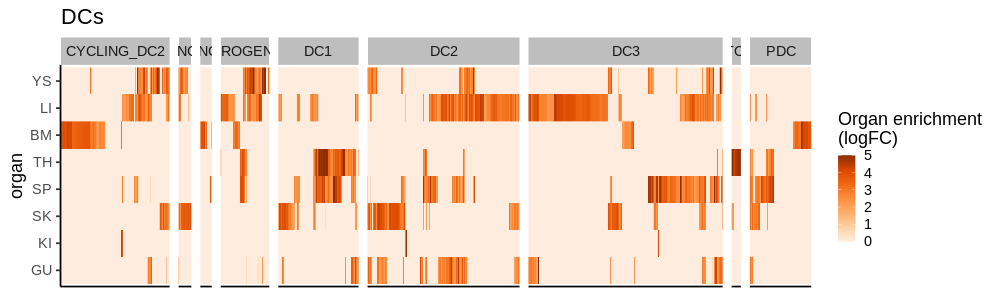

In [177]:
%%R -w 1000 -h 300
plot_organ_FC_hm_group(plot_df, "DCs", logFC_limits = c(0,5))

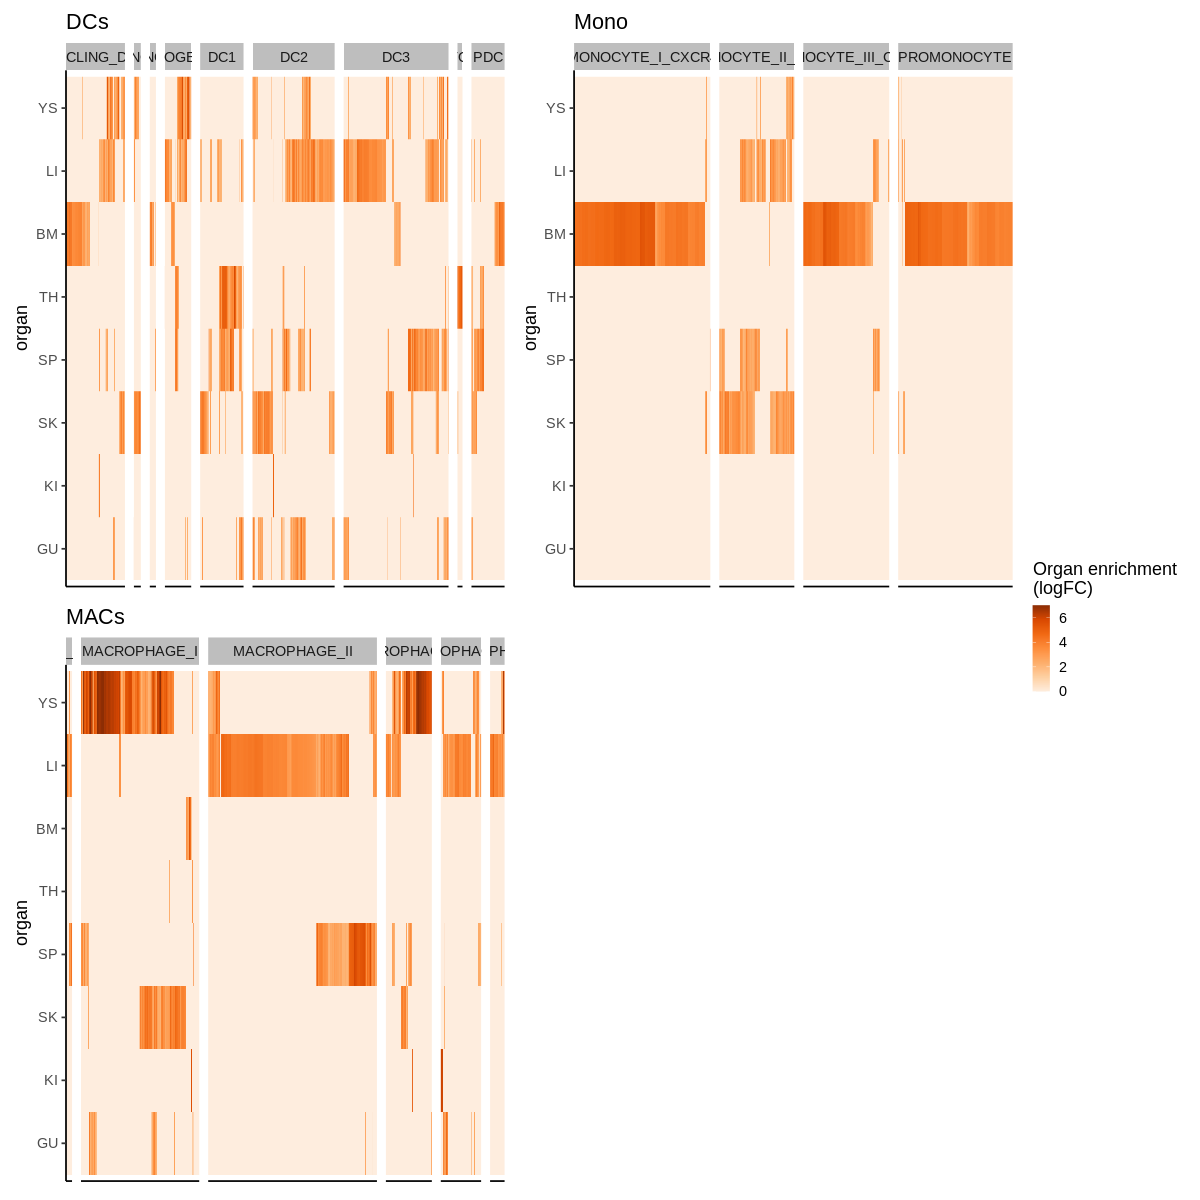

In [178]:
%%R -w 1200 -h 1200
pl_ls <- lapply(unique(plot_df$anno_group), function(g) plot_organ_FC_hm_group(plot_df, g))
wrap_plots(pl_ls[1:3], ncol=2, nrow=2) +
    plot_layout(guides='collect') +
    ggsave(paste0(figdir, 'enrichment_hm_all.pdf'), width=20, height=7) +
    ggsave(paste0(figdir, 'enrichment_hm_all.png'), width=20, height=7)

### Save outputs

In [267]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_organ_outs/{s}/'.format(s=split)
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Save dataframe for beeswarm plot
plot_df.to_csv(outdir + "milo_heatmap_plot_data.{s}.csv".format(s=split))

In [268]:
## Save processed anndata object
nhood_adata = adata.uns["nhood_adata"].copy()
del adata.uns["nhood_adata"]
adata.write_h5ad(outdir + "adata4milo_organ.{s}.h5ad".format(s=split))
adata.uns["nhood_adata"] = nhood_adata.copy()

nhood_adata.uns["annotation_labels"] = nhood_adata.uns["annotation_labels"].tolist()
nhood_adata.write_h5ad(outdir + "milo_organ_nhood_adata.{s}.h5ad".format(s=split))

... storing 'nhood_annotation' as categorical


### Organ / age distribution

In [144]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

In [145]:
anno_obs = anno_obs.loc[adata.obs_names]

In [146]:
anno_group_myeloid = {
    "Progenitors":['CMP','DC_PROGENITOR','GMP','MOP','MYELOCYTE','PROMONOCYTE','PROMYELOCYTE'],
    "Granulocytes":['NEUTROPHIL', 'MAST_CELL', 'EOSINOPHIL_BASOPHIL'],
    'DCs':[x for x in anno_obs.anno_lvl_2_final_clean.unique() if "DC" in x],
    "Mono":[x for x in anno_obs.anno_lvl_2_final_clean.unique() if x.startswith("MONO")],
    "MACs":[x for x in anno_obs.anno_lvl_2_final_clean.unique() if "ACROPHAGE" in x or "MICROGLIA" in x]
    }

anno_group_myeloid['other'] = [x for x in anno_obs.anno_lvl_2_final_clean.unique() if x not in sum(anno_group_myeloid.values(),[])]
anno_group_myeloid_rev = {x:g for g,a in anno_group_myeloid.items() for x in a}

## Exclude low quality
anno_group_myeloid_rev = {k:("other" if k in anno_groups_dict['OTHER'] else v) for k,v in anno_group_myeloid_rev.items()}
anno_group_myeloid = dict()
for k,v in anno_group_myeloid_rev.items():
    if v not in anno_group_myeloid.keys(): 
        anno_group_myeloid[v] = []
    anno_group_myeloid[v].append(k)

In [147]:
org_count_df = anno_obs.groupby(["organ", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
org_count_df["anno_group"] = [anno_group_myeloid_rev[x] if x in anno_group_myeloid_rev.keys() else np.nan for x in org_count_df.anno_lvl_2_final_clean]
# org_count_df.loc[org_count_df["anno_group"].isna(), "anno_group"] = "ERYTHROID CELLS"
org_count_df["anno"] = org_count_df["anno_lvl_2_final_clean"]

In [148]:
org_colors = pd.read_csv("../../metadata/organ_colors.csv", index_col=0)

In [149]:
age_count_df = anno_obs.groupby(["age", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
age_count_df["anno_group"] = [anno_group_myeloid_rev[x] if x in anno_group_myeloid_rev.keys() else np.nan for x in age_count_df.anno_lvl_2_final_clean]
age_count_df["anno"] = age_count_df["anno_lvl_2_final_clean"]

In [154]:
age_count_df

,age,anno_lvl_2_final_clean,file,anno_group,anno
0,4,AS_DC,1,DCs,AS_DC
1,4,CMP,35,Progenitors,CMP
2,4,CYCLING_DC2,130,DCs,CYCLING_DC2
3,4,CYCLING_DC3,17,DCs,CYCLING_DC3
4,4,CYCLING_PDC,4,DCs,CYCLING_PDC
...,...,...,...,...,...
363,17,OSTEOCLAST,72,other,OSTEOCLAST
364,17,PDC,370,DCs,PDC
365,17,PRE_DC2,34,DCs,PRE_DC2
366,17,PROMONOCYTE,1245,Progenitors,PROMONOCYTE


In [150]:
anno_group_order = ['Progenitors', 'Granulocytes', 'DCs', 'Mono', 'MACs', 'other']

In [171]:
%%R -i age_count_df -i figdir -i anno_group_order -w 800 -h 1000
age_pl_df <- age_count_df %>%
#     mutate(anno_group= ifelse(anno=="INTERSTITIAL CELLS OF CAJAL", "STROMA", anno_group)) %>%
#     mutate(anno_group= ifelse(anno=="LOW_Q_INCONSISTENT", "OTHER", anno_group)) %>%
    rename(N_cells = file) %>%
    group_by(anno) %>%
    mutate(max_age = age[which.max(N_cells)])  %>% ## At which age there are most cells?
    mutate(min_age = min(age[which(N_cells > 10)]))  %>%
    ungroup() %>%
    arrange(- max_age) %>%
    mutate(anno=factor(anno, levels=unique(anno))) %>%
    mutate(anno_group = factor(anno_group, levels=anno_group_order))
    
p2 <- age_pl_df %>%
    filter(N_cells > 10) %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=age),position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~., space="free", scales="free") +
    scale_fill_viridis_c() +
    theme_bw(base_size=18) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    expand_limits(y = 1.2) +
    geom_text(data=. %>% group_by(anno) %>% 
              summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
              hjust=0, size=5,
              y=1.01, aes(label=paste("N =", N_cells))
             ) 
    
# p2 +
#     ggsave(paste0(figdir, "age_distribution.pdf"), height=15, width=12) +
#     ggsave(paste0(figdir, "age_distribution.png"), height=15, width=12) 

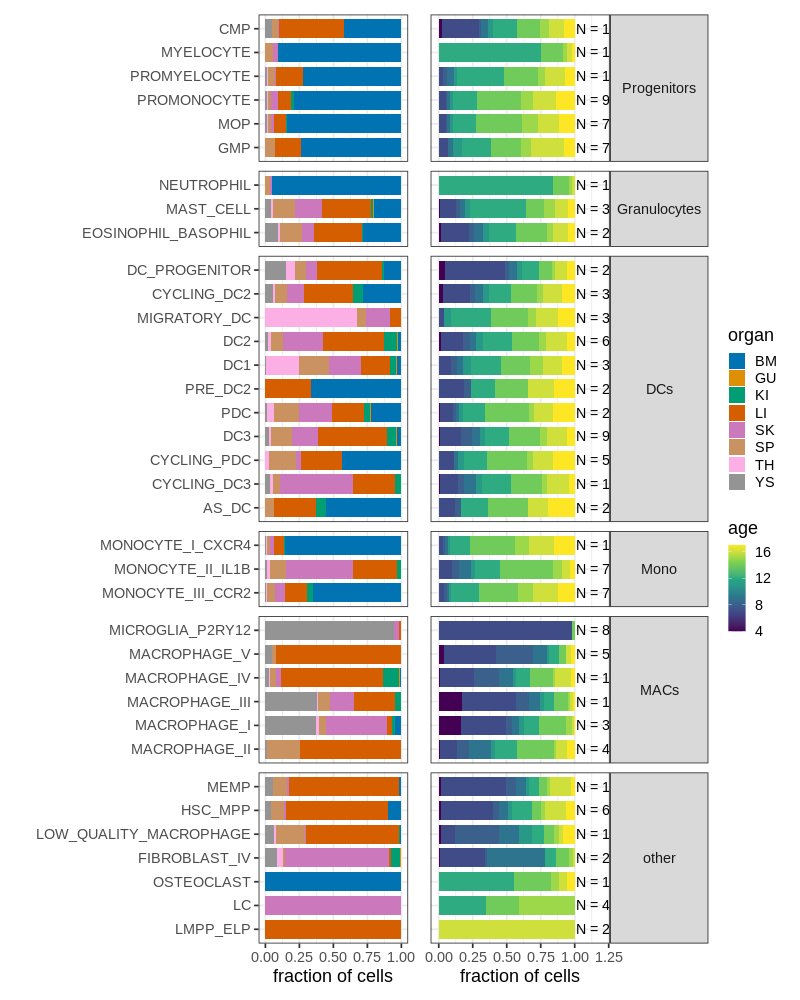

In [172]:
%%R -i org_count_df -i org_colors -i figdir -w 800 -h 1000
org_palette <- setNames(org_colors$color, org_colors$organ)
org_pl_df <- org_count_df %>%
    rename(N_cells = file) %>%
    mutate(anno=factor(anno, levels=levels(age_pl_df$anno))) %>%
    mutate(anno_group = factor(anno_group, levels=anno_group_order))

p1 <- org_pl_df %>%
    filter(N_cells > 10) %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=organ) ,position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~., space="free", scales="free") +
    scale_fill_manual(values=org_palette) +
    theme_bw(base_size=18) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    theme(strip.background=element_blank(), strip.text.y = element_blank())
#     geom_text(data=. %>% group_by(anno) %>% 
#               summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
#               hjust=0,
#               y=1.01, aes(label=paste("N =", N_cells))
#              ) +

(p1 + (p2 + remove_y_axis())) +
plot_layout(widths=c(1,1.2), guides="collect") +
    ggsave(paste0(figdir, "organ_age_distribution.pdf"), height=15, width=15) +
    ggsave(paste0(figdir, "organ_age_distribution.png"), height=15, width=15) 

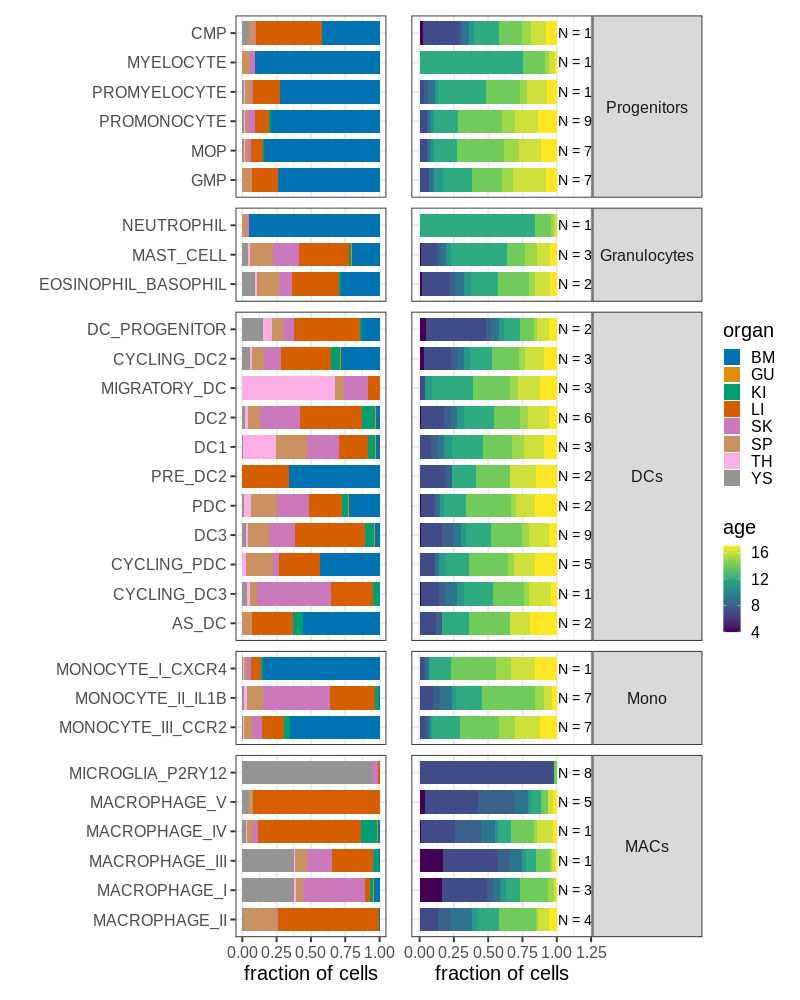

In [175]:
%%R -i age_count_df -i figdir -i anno_group_order -i org_colors -w 800 -h 1000
age_pl_df <- age_count_df %>%
    rename(N_cells = file) %>%
    group_by(anno) %>%
    mutate(max_age = age[which.max(N_cells)])  %>% ## At which age there are most cells?
    mutate(min_age = min(age[which(N_cells > 10)]))  %>%
    ungroup() %>%
    arrange(- max_age) %>%
    mutate(anno=factor(anno, levels=unique(anno))) %>%
    filter(anno_group!='other') %>%
    mutate(anno_group = factor(anno_group, levels=anno_group_order))
    
p2 <- age_pl_df %>%
    filter(N_cells > 10) %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=age),position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~., space="free", scales="free") +
    scale_fill_viridis_c() +
    theme_bw(base_size=20) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    expand_limits(y = 1.2) +
    geom_text(data=. %>% group_by(anno) %>% 
              summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
              hjust=0, size=5,
              y=1.01, aes(label=paste("N =", N_cells))
             ) 
    
org_palette <- setNames(org_colors$color, org_colors$organ)
org_pl_df <- org_count_df %>%
    rename(N_cells = file) %>%
    mutate(anno=factor(anno, levels=levels(age_pl_df$anno))) %>%
    filter(anno_group!='other') %>%
    mutate(anno_group = factor(anno_group, levels=anno_group_order)) 

p1 <- org_pl_df %>%
    filter(N_cells > 10) %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=organ) ,position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~., space="free", scales="free") +
    scale_fill_manual(values=org_palette) +
    theme_bw(base_size=20) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    theme(strip.background=element_blank(), strip.text.y = element_blank())
#     geom_text(data=. %>% group_by(anno) %>% 
#               summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
#               hjust=0,
#               y=1.01, aes(label=paste("N =", N_cells))
#              ) +

(p1 + (p2 + remove_y_axis())) +
plot_layout(widths=c(1,1.2), guides="collect") +
    ggsave(paste0(figdir, "organ_age_distribution_clean.pdf"), height=10, width=15) +
    ggsave(paste0(figdir, "organ_age_distribution_clean.png"), height=10, width=15) 

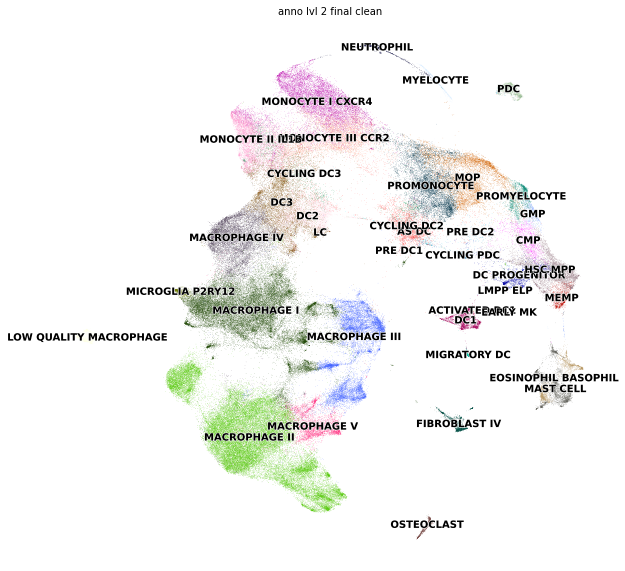

In [131]:
plt.rcParams['figure.figsize'] = [10,10]
scv.pl.umap(adata, color='anno_lvl_2_final_clean')